# Лаборатореая работа №1 по предмету «Машинное Обучени»
**Выполнил: Жаворонков Никита Дмитриевич**

### Подключение билиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Разведочный анализ данных (EDA)

In [2]:
def do_eda(df, target_col):
    plt.figure(figsize=(6,4))
    sns.histplot(df[target_col], kde=True, color='royalblue')
    plt.title(f'Распределение {target_col}')
    plt.show()

    corr = df.select_dtypes(include=np.number).corr()
    
    plt.figure(figsize=(20,16))
    sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), cmap='vlag')
    plt.title(f'Матрица корреляций')
    plt.tight_layout()
    plt.show()

    print(f'Список признаков по силе корреляции с {target_col}')
    print(corr[target_col].sort_values(ascending=False, key=abs).to_string())

    corr_pairs = []
    corr_values = corr.columns.tolist()
    for i in range(len(corr_values)):
        for j in range(i + 1, len(corr_values)):
            f1 = corr_values[i]
            f2 = corr_values[j]
            value = corr.iloc[i, j]
            corr_pairs.append({
                'f1': f1,
                'f2': f2,
                'corr': value,
                'score': abs(value),
            })
    
    corr_pairs.sort(key=lambda x: x['score'], reverse=True)
    _, axes = plt.subplots(3, 3,  figsize=(18, 20))
    for i, pair in enumerate(corr_pairs[:9]):
        ax = axes[i // 3, i % 3]
        fx = pair['f1']
        fy = pair['f2']
        value = pair['corr']
        sns.scatterplot(data=df.sample(min(10_000, len(df))), x=fx, y=fy, ax=ax)
        ax.set_title(f'{fx} vs {fy} ({value:.3f})')
        ax.set_xlabel(fx)
        ax.set_ylabel(fy)

### Выводы из разведочного анализа

***Примечание: графики EDA (разведочного анализа) находятся в конце файла.***

По результатам разведочного анализа мы видим низкую корреляцию (всего 0.023 в лучшем случае) целевой переменной с существующими признаками. Это значит, что придется провести конструирование признаков (feature engineering).

По результатам разведочного анализа мы видим сразу несколько признаков которые линейно зависимы друг от друга (наблюдается мультиколлинеарность).Как известно, качество результатов линейной регресси страдает при мультиколлинеарности. Чтобы решить данную проблему требуется произвести регуляризацию.

### Вставление пропусков

Датасет содержит пропуски в данных (NaN), для корректной работы линейной регрессии их нужно заполнить.

In [3]:
class MyMissingValueImputer:
    def __init__(self):
        pass
    def transform(self, x):
        return x.fillna(x.median())

### Кодирование нечисловых признаков

*Пояснение: модели линейной регрессии работают только с признаками которые можно выразить численно. Нечисловые признаки необходимо преобразовать.*

In [4]:
class MyCategoricalEncoder:
    def __init__(self):
        pass
    def transform(self, x):
        # Кодируем дату как количество дней от 1 Января 1970 (начало POSIX времени).
        date_col = 'ApplicationDate'
        unix_epoch = pd.to_datetime('1970-01-01')
        x[date_col] = (pd.to_datetime(x[date_col]) - unix_epoch).dt.days

        # Кодируем уровень образования
        edu_col = 'EducationLevel'
        edu_ordering = {
            'High School' : 1,
            'Associate' : 2,
            'Bachelor': 3,
            'Master': 4,
            'Doctorate': 5,
        }
        x[edu_col] = x[edu_col].map(edu_ordering).astype(float)

        # Кодируем семейный статус
        #
        # Примечание: лучше не использовать порядковое кодирование, т.к.
        # неуместно говорить о строгом порядке. Вместо этого создадим 
        # воспользуемся One-Hot Encoding.
        marital_col = 'MaritalStatus'
        married_col = 'IsMarried'
        divorced_col = 'IsDivorced'
        widowed_col = 'IsWidowed'
        marital_missing_col = 'IsMaritalStatusMissing'
        x[married_col] = (x[marital_col] == 'Married').astype(int)
        x[divorced_col] = (x[marital_col] == 'Divorced').astype(int)
        x[widowed_col] = (x[marital_col] == 'Widowed').astype(int)
        x[marital_missing_col] = (x[marital_col].isna()).astype(int)
        x = x.drop(marital_col, axis=1)

        # Кодируем статус владения недвижимостью
        ownership_col = 'HomeOwnershipStatus'
        rent_col = 'IsRentingHouse'
        mortgage_col = 'HasHouseOnMortgage'
        own_col = 'IsOwningHouse'
        ownership_missing_col = 'IsHomeOwnershipStatusMissing'
        x[rent_col] = (x[ownership_col] == 'Rent').astype(int)
        x[mortgage_col] = (x[ownership_col] == 'Mortgage').astype(int)
        x[own_col] = (x[ownership_col] == 'Own').astype(int)
        x[ownership_missing_col] = (x[ownership_col].isna()).astype(int)
        x = x.drop(ownership_col, axis=1)

        # Кодируем причину займа
        loan_col = 'LoanPurpose'
        loan_edu_col = 'IsLoaningForEducation'
        loan_home_col = 'IsLoaningForHouse'
        loan_debt_col = 'IsLoaningForDebtConsolidation'
        loan_auto_col = 'IsLoaningForAutomobile'
        loan_missing_col = 'IsLoanPurposeMissing'
        x[loan_edu_col] = (x[loan_col] == 'Education').astype(int)
        x[loan_home_col] = (x[loan_col] == 'Home').astype(int)
        x[loan_debt_col] = (x[loan_col] == 'Debt Consolidation').astype(int)
        x[loan_auto_col] = (x[loan_col] == 'Auto').astype(int)
        x[loan_missing_col] = (x[loan_col].isna()).astype(int)
        x = x.drop(loan_col, axis=1)

        # Кодируем статус занятости
        employment_col = 'EmploymentStatus'
        empl_comp_col = 'IsEmployedToCompany'
        empl_self_col = 'IsSelfEmployed'
        unempl_col = 'IsUnemployed'
        empl_missing_col = 'IsEmploymentStatusMissing'
        x[empl_comp_col] = (x[employment_col] == 'Employed').astype(int)
        x[empl_self_col] = (x[employment_col] == 'Self-Employed').astype(int)
        x[unempl_col] = (x[employment_col] == 'Unemployed').astype(int)
        x[empl_missing_col] = (x[employment_col].isna()).astype(int)
        x = x.drop(employment_col, axis=1)
        
        return x

### Конструирование признаков

In [5]:
class MyFeatureEngineer:
    def transform(self, x):
        x = x.copy()
        
        # Финансовые отношения
        x['IncomeToLoanRatio'] = x['AnnualIncome'] / (x['LoanAmount'] + 1)
        x['LoanToIncomeLog'] = np.log1p(x['LoanAmount']) - np.log1p(x['AnnualIncome'])
        
        # Кредитные метрики
        x['CreditInterestScore'] = x['CreditScore'] / (x['InterestRate'] * 100 + 1)
        
        # Возрастные отношения
        x['ExperienceToAge'] = x['Experience'] / (x['Age'] + 1)
        x['YearsAfterEducation'] = x['Age'] - x['Experience'] - 18
        
        # Долговые нагрузки
        x['DebtBurden'] = x['MonthlyDebtPayments'] / (x['MonthlyIncome'] + 1)
        x['DebtBurdenSquared'] = x['DebtBurden'] ** 2

        x['InterestRateSpread'] = x['InterestRate'] - x['BaseInterestRate']

        total_debt = x['MonthlyLoanPayment'] + x['MonthlyDebtPayments']
        x['DebtServiceRatio'] = total_debt / (x['MonthlyIncome'] + 1e-5)
        x['DisposableIncome'] = x['MonthlyIncome'] - total_debt

        x['AssetCoverage'] = x['TotalAssets'] / (x['TotalLiabilities'] + 1e-5)
        x['NetWorthRatio'] = (x['TotalAssets'] - x['TotalLiabilities']) / (x['TotalAssets'] + 1e-5)

        x['UtilizationPerLine'] = x['CreditCardUtilizationRate'] / (x['NumberOfOpenCreditLines'] + 1)
        x['InquiryPerLine'] = x['NumberOfCreditInquiries'] / (x['NumberOfOpenCreditLines'] + 1)
        x['CreditAgeRatio'] = x['CreditScore'] / (x['Age'] + 1e-5)
        x['LoanDurationYears'] = x['LoanDuration'] / 12.0

        for feature in ['CreditScore', 'AnnualIncome', 'LoanAmount', 'Age', 'TotalAssets']:
            x[f'{feature}_squared'] = x[feature] ** 2

        x['RiskMultiplier'] = (x['NumberOfCreditInquiries'] * x['CreditCardUtilizationRate']) / (x['CreditScore'] + 100)
    
        x['SolvencyScore'] = np.log1p(x['AnnualIncome']) - np.log1p(x['TotalLiabilities'] + 12 * x['MonthlyDebtPayments'])
    
        x['WeightedCreditScore'] = (
            x['CreditScore'] * 0.6 + 
            x['PaymentHistory'] * 0.3 + 
            np.log1p(x['LengthOfCreditHistory']) * 0.1
        )
    
        x['DebtIncomeInteraction'] = x['TotalDebtToIncomeRatio'] * np.exp(-x['MonthlyIncome'] / 5000)
    
        for feature in ['CreditScore', 'AnnualIncome', 'LoanAmount']:
            if feature in x.columns:
                x[f'{feature}_cubed'] = x[feature] ** 3
                x[f'{feature}_sqrt'] = np.sqrt(abs(x[feature]) + 1)
        
        # Логарифмирование skewed features
        for col in ['AnnualIncome', 'TotalAssets', 'LoanAmount', 'NetWorth']:
            x[f'log_{col}'] = np.log1p(x[col].clip(lower=0))
        
        # Взаимодействия
        x['CreditAge'] = x['CreditScore'] * x['Age'] / 1000

        x['IncomePerDependent'] = x['AnnualIncome'] / (x['NumberOfDependents'] + 1)

        x['DefaultIndex'] = (
            (100 - x['PaymentHistory']) * 0.4 +        # Низкая история платежей
            x['PreviousLoanDefaults'] * 100 * 0.3 +    # Предыдущие дефолты
            x['BankruptcyHistory'] * 200 * 0.2 +       # Банкротство
            (850 - x['CreditScore']) * 0.1             # Низкий кредитный рейтинг
        )
    
        x['OverLeverageIndex'] = (
            np.tanh(x['TotalDebtToIncomeRatio'] * 2) * 50 +          # Высокий долг/доход
            np.tanh(x['CreditCardUtilizationRate'] * 3) * 30 +       # Высокая утилизация
            np.tanh(x['NumberOfOpenCreditLines'] / 20) * 10 +        # Много кредитов
            np.tanh(x['NumberOfCreditInquiries'] / 5) * 10           # Много запросов
        )
    
        debt_service = x['MonthlyDebtPayments'] + x['MonthlyLoanPayment']
        x['FinancialStress'] = debt_service / (x['MonthlyIncome'] + 1e-5)
        x['FinancialStressSquared'] = x['FinancialStress'] ** 2
        x['FinancialStressCubed'] = x['FinancialStress'] ** 3
    
        # U-образная зависимость: риск высок у молодых, снижается, растет у пожилых
        x['AgeRisk'] = ((x['Age'] - 45) ** 2) / 1000  # Минимум риска в 45 лет
    
        risk_factors = []
        weights = []
        risk_factors.append((850 - x['CreditScore']) / 850)  # 0-1, где 1 - максимальный риск
        weights.append(0.25)
        risk_factors.append((100 - x['PaymentHistory']) / 100)
        weights.append(0.25)
        risk_factors.append(np.tanh(x['TotalDebtToIncomeRatio'] * 2))
        weights.append(0.20)
        risk_factors.append(x['CreditCardUtilizationRate'])
        weights.append(0.15)
        risk_factors.append(np.tanh(x['NumberOfCreditInquiries'] / 10))
        weights.append(0.15)
        total_weight = sum(weights)
        weights = [w / total_weight for w in weights]
        x['CompositeRiskScore'] = sum(r * w for r, w in zip(risk_factors, weights)) * 100
    
        x['CreditDebtInteraction'] = x['CreditScore'] * x['TotalDebtToIncomeRatio'] / 1000
        x['CreditDebtRatio'] = x['CreditScore'] / (x['TotalDebtToIncomeRatio'] * 100 + 1)
        x['ExperienceDeficit'] = x['Age'] - x['Experience'] - 20
        x['ExperienceDeficitSquared'] = x['ExperienceDeficit'] ** 2

        x['InquiryIntensity'] = x['NumberOfCreditInquiries'] / np.sqrt(x['LengthOfCreditHistory'] + 1)
    
        x['CreditHistoryFatigue'] = 1 - np.exp(-x['LengthOfCreditHistory'] / 10)
    
        x['AgeRiskWave_1'] = np.sin(2 * np.pi * x['Age'] / 25)  # 25-летний цикл
        x['AgeRiskWave_2'] = np.cos(2 * np.pi * x['Age'] / 15)  # 15-летний цикл
    
        x['CumulativeRiskTime'] = (
            x['Age'] * 0.4 + 
            x['Experience'] * 0.3 + 
            x['JobTenure'] * 0.3
        )

        # rank_features = ['CreditScore', 'AnnualIncome', 'LoanAmount', 'TotalAssets']
        # for col in rank_features:
        #     # Простой ранг
        #     x[f'{col}_Rank'] = x[col].rank(pct=True)
            
        #     # Преобразование ранга в нормальное распределение
        #     from scipy.stats import norm
        #     x[f'{col}_NormRank'] = norm.ppf(x[f'{col}_Rank'].clip(0.001, 0.999))
        
        # # 6. **Полиномы 4-й степени для топ-3 признаков**
        # top_features = ['CreditScore', 'AnnualIncome', 'TotalDebtToIncomeRatio']
        # for feature in top_features:
        #     x[f'{feature}_pow4'] = x[feature] ** 4
        #     x[f'{feature}_log1p_squared'] = np.log1p(abs(x[feature])) ** 2

        return x

### Нормализация данных

In [6]:
SCALE_METHOD_ZSCORE = 'zscore'
SCALE_METHOD_MINMAX = 'minmax'
SCALE_EPS = 1e-5

class MyFeatureScaler:
    def __init__(self, method = SCALE_METHOD_ZSCORE):
        self._method = method  # 'zscore', 'minmax'
        self._mean = None
        self._std = None
        self._min = None
        self._max = None
    def fit(self, x):
        if self._method == SCALE_METHOD_ZSCORE:
            self._mean = x.mean()
            self._std = x.std().replace(0, SCALE_EPS)
        elif self._method == SCALE_METHOD_MINMAX:
            self._min = x.min()
            self._max = x.max()
        else:
            raise ValueError(f"Неизвестный метод нормализации: '{self._method}'")
    def transform(self, x):
        if self._method == SCALE_METHOD_ZSCORE:
            x = (x - self._mean) / self._std
        elif self._method == SCALE_METHOD_MINMAX:
            x = (x - self._min) / (self._max - self._min + SCALE_EPS)
        else:
            raise ValueError(f"Неизвестный метод нормализации: '{self._method}'")
        
        return x

### Линейная регрессия

Текущая реализация поддерживает как выбор метода поиска экстремума, так и метода регуляризации.

In [7]:
LR_METHOD_ANALYTICAL = 'analytical'
LR_METHOD_GD = 'gd'
LR_METHOD_SGD = 'sgd'
LR_REGULARIZATION_L1 = 'l1'
LR_REGULARIZATION_L2 = 'l2'
LR_REGULARIZATION_L1L2 = 'elastic'
LR_REGULARIZATION_LP = 'lp'

class MyLinearRegression:
    def __init__(self, method=LR_METHOD_ANALYTICAL, regularization=None, 
                 alpha=0.1, l1_ratio=0.5, p=2.0, learning_rate=0.01,
                 max_iter=1000, batch_size=32, tol=1e-4, verbose=False):
        self.method = method  # 'analytical', 'gd', 'sgd'
        self.regularization = regularization  # 'l1', 'l2', 'elastic', 'lp'
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.p = max(p, 1.0)  # Защита от p < 1
        self.lr = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.tol = tol
        self.verbose = verbose
        self.weights = None
        self.bias = 0.0
        self.loss_history = []

    def _regularization_gradient(self):
        if self.regularization is None:
            return 0
        
        eps = 1e-8
        w = self.weights
        
        if self.regularization == LR_REGULARIZATION_L1:
            return self.alpha * np.sign(w)
        elif self.regularization == LR_REGULARIZATION_L2:
            return 2 * self.alpha * w
        elif self.regularization == LR_REGULARIZATION_L1L2:
            l1_grad = self.l1_ratio * np.sign(w)
            l2_grad = 2 * (1 - self.l1_ratio) * w
            return self.alpha * (l1_grad + l2_grad)
        elif self.regularization == LR_REGULARIZATION_LP:
            return self.alpha * self.p * (np.abs(w) + eps) ** (self.p - 1) * np.sign(w)
        return 0

    def _regularization_loss(self):
        if self.regularization is None:
            return 0
        
        w = self.weights
        eps = 1e-8
        
        if self.regularization == LR_REGULARIZATION_L1:
            return self.alpha * np.sum(np.abs(w))
        elif self.regularization == LR_REGULARIZATION_L2:
            return self.alpha * np.sum(w ** 2)
        elif self.regularization == LR_REGULARIZATION_L1L2:
            l1 = self.l1_ratio * np.sum(np.abs(w))
            l2 = (1 - self.l1_ratio) * np.sum(w ** 2)
            return self.alpha * (l1 + l2)
        elif self.regularization == LR_REGULARIZATION_LP:
            return self.alpha * np.sum((np.abs(w) + eps) ** self.p)
        return 0

    def fit(self, x, y):
        x = np.array(x, dtype=np.float64)
        y = np.array(y, dtype=np.float64).ravel()
        n_samples, n_features = x.shape
        
        if self.method == LR_METHOD_ANALYTICAL:
            xb = np.column_stack([np.ones(n_samples), x])
            
            if self.regularization == LR_REGULARIZATION_L2:
                reg_matrix = self.alpha * np.eye(n_features + 1)
                reg_matrix[0, 0] = 0  # Не регуляризуем bias
                theta = np.linalg.pinv(xb.T @ xb + reg_matrix) @ xb.T @ y
            else:
                if self.regularization not in [None, LR_REGULARIZATION_L2]:
                    raise ValueError(f"Аналитический метод не поддерживает регуляризацию {self.regularization}")
                theta = np.linalg.pinv(xb.T @ xb) @ xb.T @ y
            
            self.bias = theta[0]
            self.weights = theta[1:]
            
        else:  # Градиентные методы
            self.weights = np.zeros(n_features)
            self.bias = 0.0
            
            for epoch in range(self.max_iter):
                if self.method == LR_METHOD_GD:
                    predictions = x @ self.weights + self.bias
                    error = predictions - y
                    
                    dw = (2 / n_samples) * x.T @ error
                    db = (2 / n_samples) * np.sum(error)
                    
                elif self.method == LR_METHOD_SGD:
                    indices = np.random.permutation(n_samples)
                    dw = np.zeros(n_features)
                    db = 0.0
                    n_batches = 0
                    
                    for i in range(0, n_samples, self.batch_size):
                        batch_end = min(i + self.batch_size, n_samples)
                        batch_idx = indices[i:batch_end]
                        X_batch = x[batch_idx]
                        y_batch = y[batch_idx]
                        
                        predictions = X_batch @ self.weights + self.bias
                        error = predictions - y_batch
                        
                        dw += (2 / len(batch_idx)) * X_batch.T @ error
                        db += (2 / len(batch_idx)) * np.sum(error)
                        n_batches += 1
                    
                    dw /= n_batches
                    db /= n_batches
                
                # Добавляем регуляризацию (кроме bias)
                dw += self._regularization_gradient()
                
                self.weights -= self.lr * dw
                self.bias -= self.lr * db
                
                if epoch % 100 == 0:
                    predictions = x @ self.weights + self.bias
                    mse = np.mean((y - predictions) ** 2)
                    total_loss = mse + self._regularization_loss()
                    self.loss_history.append(total_loss)
                    
                    if self.verbose:
                        print(f"Epoch {epoch}: Loss = {total_loss:.6f}")
                    
                    if len(self.loss_history) > 1 and abs(self.loss_history[-2] - total_loss) < self.tol:
                        break

    def predict(self, x):
        x = np.array(x, dtype=np.float64)
        return x @ self.weights + self.bias

### Пайплайн

In [8]:
class MyPipeline:
    def __init__(self, imputer, encoder, engineer, scaler, selector, linear_regression):
        self.imputer = imputer
        self.encoder = encoder
        self.engineer = engineer
        self.scaler = scaler
        self.selector = selector
        self.linear_regression = linear_regression
    def fit(self, x, y):
        x = x.copy(deep=True)
        x = self.encoder.transform(x)
        x = self.imputer.transform(x)
        x = self.engineer.transform(x)
        self.scaler.fit(x)
        x = self.scaler.transform(x)
        self.selector.fit(x, y)
        x = self.selector.transform(x)
        self.linear_regression.fit(x, y)
    def predict(self, x):
        x = x.copy(deep=True)
        x = self.encoder.transform(x)
        x = self.imputer.transform(x)
        x = self.engineer.transform(x)
        x = self.scaler.transform(x)
        x = self.selector.transform(x)
        return self.linear_regression.predict(x)

### Кросс-валидатор

In [9]:
CV_METHOD_KFOLD = 'kfold'
CV_METHOD_LEAVE_ONE_OUT = 'loo'

class MyCrossValidator:
    def __init__(self, method=CV_METHOD_KFOLD, n_splits=5, shuffle=True, random_state=None):
        if n_splits <= 1:
            raise ValueError("n_splits должно быть >= 2")
        
        self.method = method
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
    
    def split(self, x, y=None):
        n_samples = len(x)
        
        if self.method == CV_METHOD_LEAVE_ONE_OUT and self.n_splits != n_samples:
            print(f"Предупреждение: n_splits должен быть равен n_samples для Leave One Out ({n_samples})")
        
        indices = np.arange(n_samples)
        
        if self.shuffle:
            if self.random_state is not None:
                rng = np.random.RandomState(self.random_state)
            else:
                rng = np.random
            rng.shuffle(indices)
        
        if self.method == CV_METHOD_KFOLD:
            if self.n_splits > n_samples:
                raise ValueError(f"n_splits={self.n_splits} должно быть больше (>) n_samples={n_samples}!")
            
            fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
            fold_sizes[:n_samples % self.n_splits] += 1
            
            current = 0
            for fold_size in fold_sizes:
                start, stop = current, current + fold_size
                test_idx = indices[start:stop]
                train_idx = np.concatenate([indices[:start], indices[stop:]])
                yield train_idx, test_idx
                current = stop
        
        elif self.method == CV_METHOD_LEAVE_ONE_OUT:
            for i in range(n_samples):
                test_idx = indices[i:i+1]
                mask = np.ones(n_samples, dtype=bool)
                mask[i] = False
                train_idx = indices[mask]
                yield train_idx, test_idx
        
        else:
            raise ValueError(f"Неизвестный метод кросс-валидации: {self.method}")

### Метрики

In [10]:
METRICS_R2_EPS = 1e-3
METRICS_MAPE_EPS = 1e-3

class MyMetrics:
    @staticmethod
    def mse(y_expected, y):
        return np.mean((y_expected - y) ** 2)
    @staticmethod
    def mae(y_expected, y):
        return np.mean(np.abs(y_expected - y))
    @staticmethod
    def r2(y_expected, y):
        return 1 - np.sum((y_expected - y) ** 2) / (np.sum((y_expected - np.mean(y_expected)) ** 2) + METRICS_R2_EPS)
    @staticmethod
    def mape(y_expected, y):
        return np.mean(np.abs((y_expected - y) / (y_expected + METRICS_MAPE_EPS)))

### Итоговое решение часть 1: EDA до преобразований

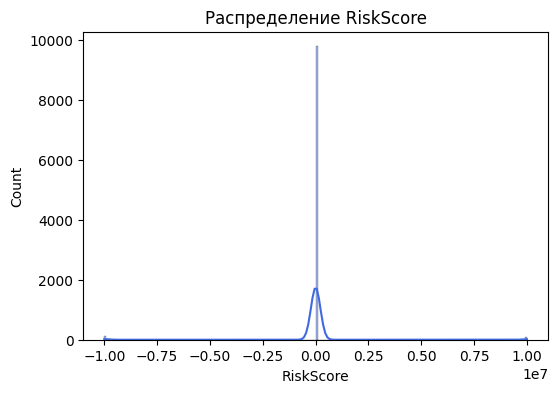

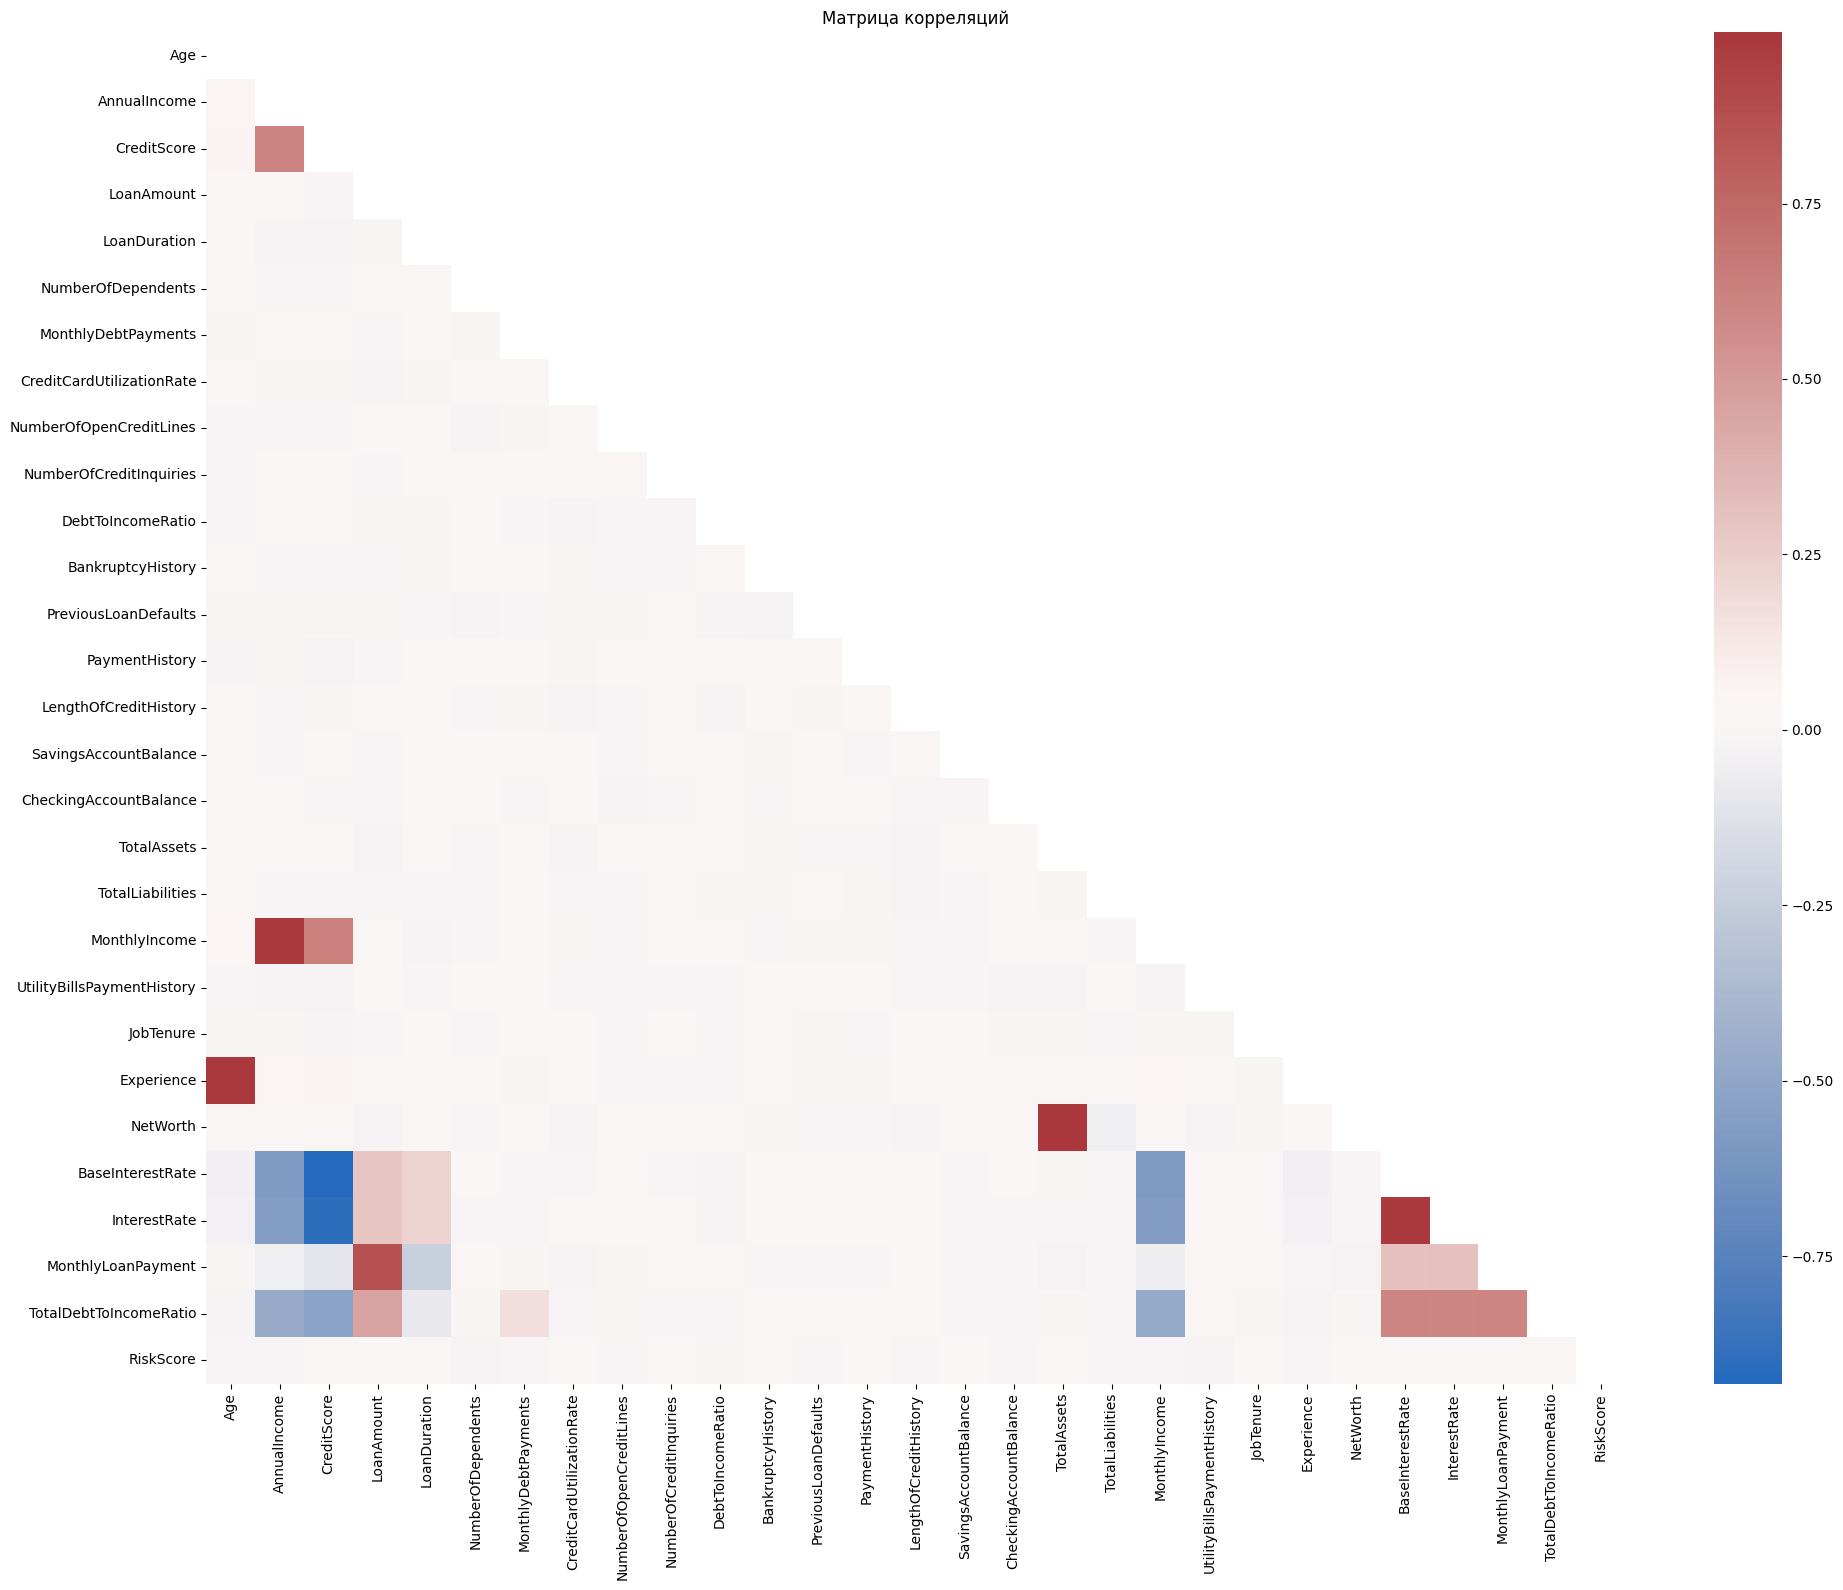

Список признаков по силе корреляции с RiskScore
RiskScore                     1.000000
NumberOfDependents           -0.021688
UtilityBillsPaymentHistory   -0.017767
PaymentHistory                0.014699
NumberOfCreditInquiries       0.013150
SavingsAccountBalance         0.012305
LoanAmount                    0.011771
TotalDebtToIncomeRatio        0.010885
MonthlyLoanPayment            0.010790
NetWorth                      0.008804
DebtToIncomeRatio            -0.008450
TotalAssets                   0.008092
CreditCardUtilizationRate     0.006510
AnnualIncome                 -0.006047
LengthOfCreditHistory        -0.005727
BankruptcyHistory             0.005184
JobTenure                     0.005168
PreviousLoanDefaults         -0.004910
InterestRate                  0.004242
TotalLiabilities             -0.004064
LoanDuration                  0.003876
MonthlyIncome                -0.003555
CreditScore                   0.002383
BaseInterestRate              0.002081
MonthlyDebtPayme

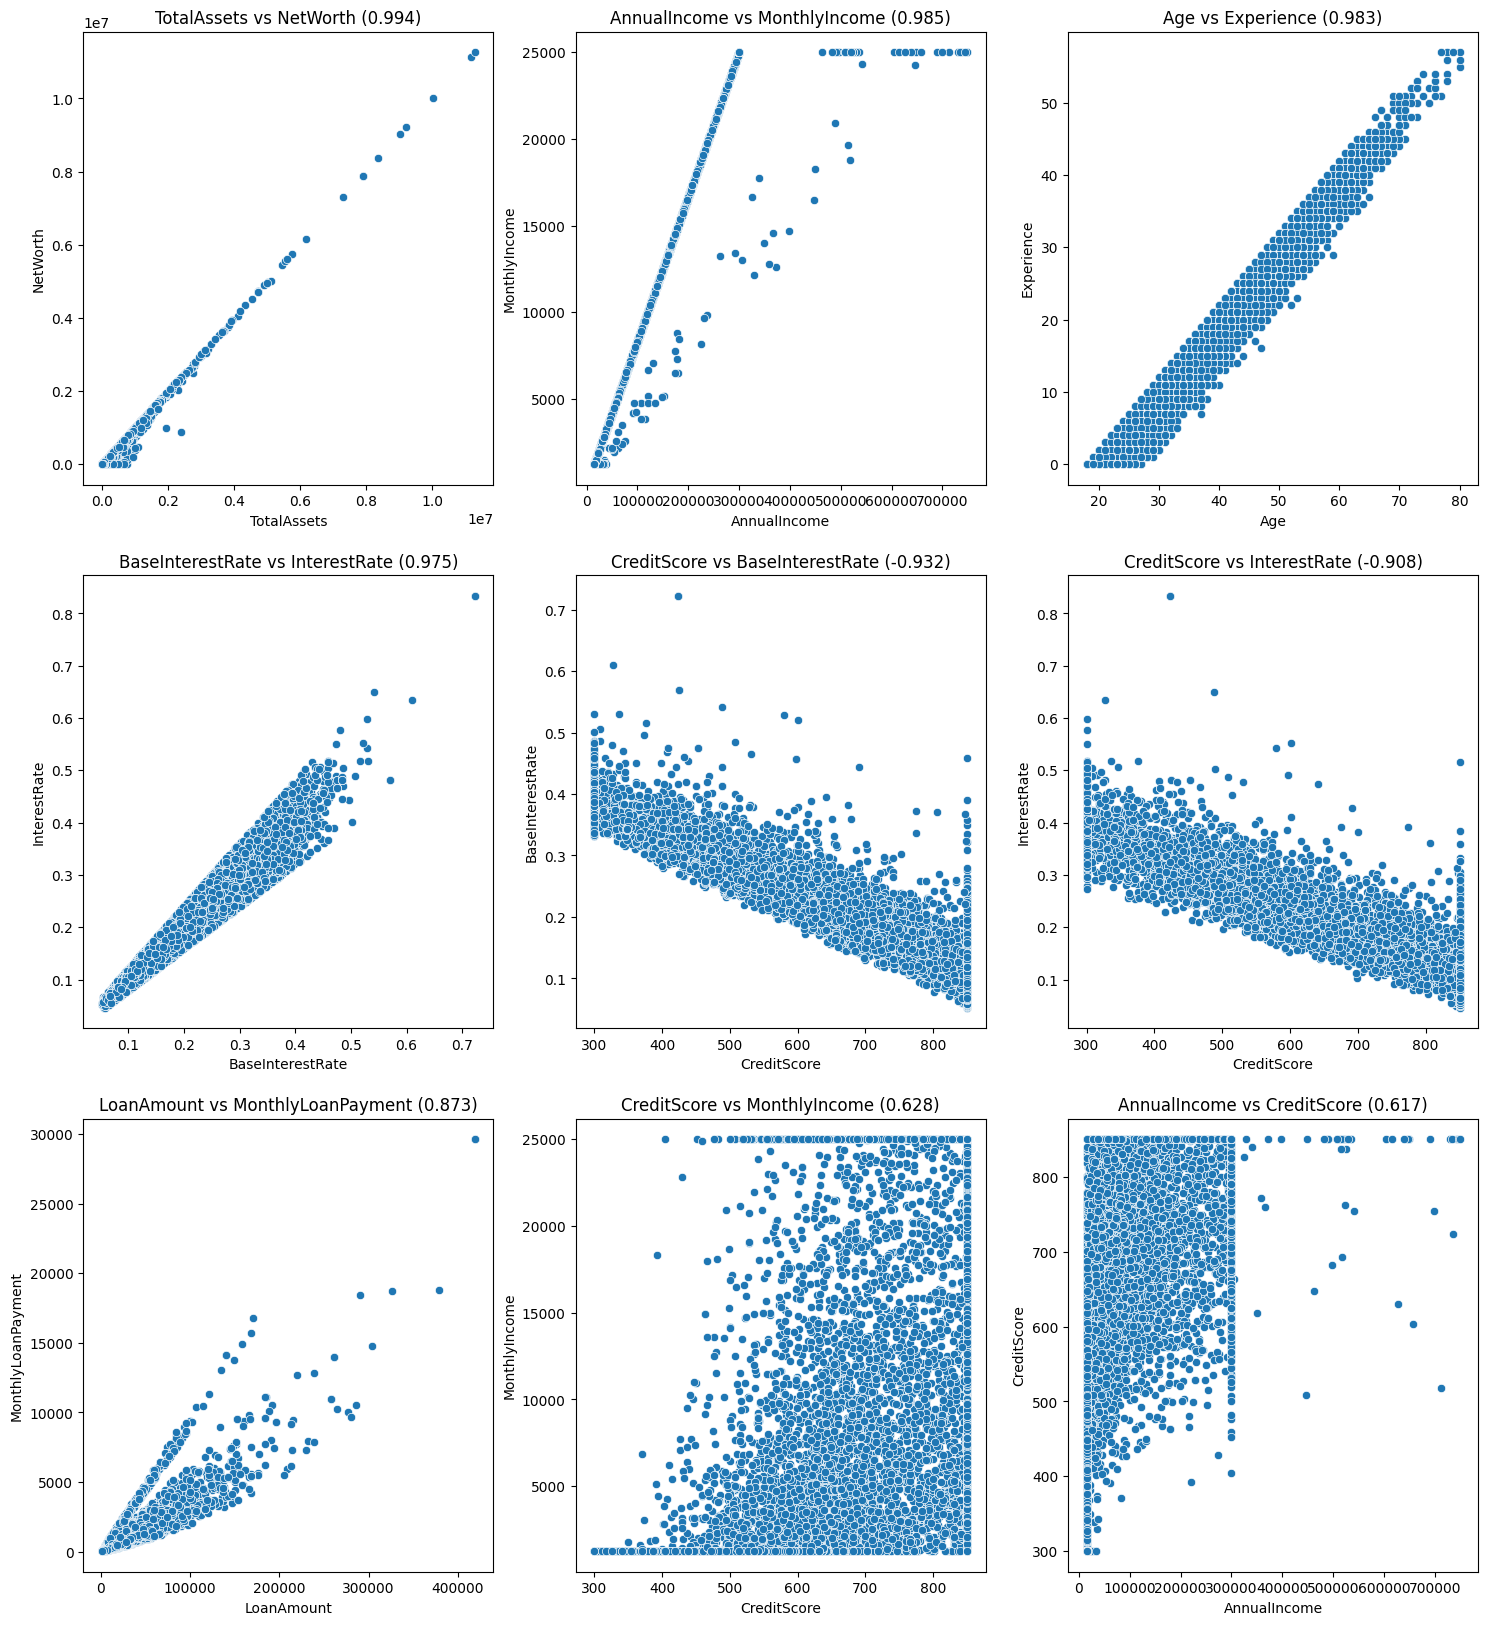

In [11]:
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Загружаем датасет
train_df = pd.read_csv('data/train.csv').dropna()
test_df = pd.read_csv('data/test.csv')

target_col = 'RiskScore'
id_col = 'ID'

# Разведочный анализ
do_eda(train_df, target_col)

### Итоговое решение часть 2: все остальное

In [12]:
# Фильтруем данные непригодные для обучения 
train_df = train_df.dropna(subset=[target_col])
train_df = train_df[train_df[target_col].abs() <= 100].reset_index(drop=True)

# Группируем данные для обучения
train_x = train_df.drop(columns=[target_col])
train_y = train_df[target_col]
test_x = test_df.drop(columns=[id_col])
test_ids = test_df[id_col]

cv = MyCrossValidator(method=CV_METHOD_KFOLD)

print('')
gd_p = float(input('Введите значение p для градиентного спуска с регуляризацией Lp'))
sgd_p = float(input('Введите значение p для стохастического градиентного спуска с регуляризацией Lp'))

print('Сравнение методов:')
verify_name = 'sklearn (проверка)'
best_score = float('inf')
best_model = None
for scale_name, scaler in [('zscore', MyFeatureScaler(method=SCALE_METHOD_ZSCORE)),
                           ('minmax', MyFeatureScaler(method=SCALE_METHOD_MINMAX))]:
    for name, linear_regression in [('аналитический', MyLinearRegression(method=LR_METHOD_ANALYTICAL)),
                                    ('аналитический L2', MyLinearRegression(method=LR_METHOD_ANALYTICAL, regularization=LR_REGULARIZATION_L2)),
                                    ('градиентный спуск', MyLinearRegression(method=LR_METHOD_GD)),
                                    ('градиентный спуск L1', MyLinearRegression(method=LR_METHOD_GD, regularization=LR_REGULARIZATION_L1)),
                                    ('градиентный спуск L2', MyLinearRegression(method=LR_METHOD_GD, regularization=LR_REGULARIZATION_L2)),
                                    ('градиентный спуск L1 + L2', MyLinearRegression(method=LR_METHOD_GD, regularization=LR_REGULARIZATION_L1L2)),
                                    ('градиентный спуск Lp', MyLinearRegression(method=LR_METHOD_GD, regularization=LR_REGULARIZATION_LP, p=gd_p)),
                                    ('стохастический градиентный спуск', MyLinearRegression(method=LR_METHOD_SGD)),
                                    ('стохастический градиентный спуск L1', MyLinearRegression(method=LR_METHOD_SGD, regularization=LR_REGULARIZATION_L1)),
                                    ('стохастический градиентный спуск L2', MyLinearRegression(method=LR_METHOD_SGD, regularization=LR_REGULARIZATION_L2)),
                                    ('стохастический градиентный спуск L1 + L2', MyLinearRegression(method=LR_METHOD_SGD, regularization=LR_REGULARIZATION_L1L2)),
                                    ('стохастический градиентный спуск Lp', MyLinearRegression(method=LR_METHOD_SGD, regularization=LR_REGULARIZATION_LP, p=sgd_p)),
                                    (verify_name, LinearRegression())]:
        p = MyPipeline(MyMissingValueImputer(), 
                    MyCategoricalEncoder(),
                    MyFeatureEngineer(),
                    scaler,
                    SelectPercentile(score_func=f_regression, percentile=70),
                    linear_regression)
        scores = []
        for idx_train, idx_test in cv.split(train_x):
            x_cv_train = train_x.iloc[idx_train].copy(deep=True)
            x_cv_test = train_x.iloc[idx_test].copy(deep=True)

            y_cv_train = train_y.iloc[idx_train].copy(deep=True)
            y_cv_test = train_y.iloc[idx_test].copy(deep=True)

            p.fit(x_cv_train, y_cv_train)

            y_perdicted = p.predict(x_cv_test)
            scores.append(MyMetrics.mse(y_cv_test, y_perdicted))
        
        mean = np.mean(scores)
        std = np.std(scores)

        if name != verify_name and mean < best_score:
            best_score = mean
            best_model = (f'{scale_name} + {name}', p)

        print(f'[CV MSE] {scale_name} + {name}: срзнач={mean} стдев={std}')

print(f'Лучшая метод по итогам кросс-валидации: {best_model[0]} со срзнач={best_score}')
print('')

p = best_model[1]
p.fit(train_x, train_y)
y_perdicted = p.predict(test_x)
y_perdicted = np.clip(y_perdicted, 0.0, 100.0)
submission = pd.DataFrame({ id_col: test_ids, target_col: y_perdicted })
out_path = 'submission.csv'
print(f'Сохраняем резултат в `{out_path}`...')
submission.to_csv(out_path, index=False)
print('Результат сохранен.')

print('')
print('Метрики и сравнение со sklearn:')
x_tr, x_ver, y_tr, y_ver = train_test_split(train_x, train_y)
p.fit(x_tr, y_tr)
y_pr = p.predict(x_ver)
print(f'MSE: моямодель={MyMetrics.mse(y_ver, y_pr)} sklearn={mean_squared_error(y_ver, y_pr)}')
print(f'MAE: моямодель={MyMetrics.mae(y_ver, y_pr)} sklearn={mean_absolute_error(y_ver, y_pr)}')
print(f'R2: моямодель={MyMetrics.r2(y_ver, y_pr)} sklearn={r2_score(y_ver, y_pr)}')
print(f'MAPE: моямодель={MyMetrics.mape(y_ver, y_pr)} sklearn={mean_absolute_percentage_error(y_ver, y_pr)}')


Сравнение методов:
[CV MSE] zscore + аналитический: срзнач=27.63725130040005 стдев=0.6486273483656338
[CV MSE] zscore + аналитический L2: срзнач=28.8180214864778 стдев=0.629547191480873
[CV MSE] zscore + градиентный спуск: срзнач=32.35612374992402 стдев=1.4195475070279924
[CV MSE] zscore + градиентный спуск L1: срзнач=32.740364446055686 стдев=0.9153864784353618
[CV MSE] zscore + градиентный спуск L2: срзнач=33.94289113760171 стдев=1.7006499512248032
[CV MSE] zscore + градиентный спуск L1 + L2: срзнач=33.2139617894025 стдев=1.199835507421288
[CV MSE] zscore + градиентный спуск Lp: срзнач=33.061252294421784 стдев=0.811088098887205
[CV MSE] zscore + стохастический градиентный спуск: срзнач=32.16321753619686 стдев=0.8024161674002189
[CV MSE] zscore + стохастический градиентный спуск L1: срзнач=32.780888262797475 стдев=1.130929896147058
[CV MSE] zscore + стохастический градиентный спуск L2: срзнач=33.914358280317764 стдев=1.40888982256444
[CV MSE] zscore + стохастический градиентный спуск 